<a href="https://colab.research.google.com/github/qri0usmind/crop_price_predictor/blob/main/sameday_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load base dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])

# One-hot encode season
df = pd.get_dummies(df, columns=['season'])

# Select features and target
X_base = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_base)
feature_names = poly.get_feature_names_out(X_base.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)
alphas = [0.01, 0.1, 1.0, 10.0]

# Lasso with CV
lasso_model = LassoCV(alphas=alphas, cv=tscv, max_iter=10000)
lasso_model.fit(X_poly_df, y)
best_alpha = lasso_model.alpha_

# Evaluate
mae_list, mse_list, r2_list = [], [], []

for train_idx, test_idx in tscv.split(X_poly_df):
    X_train, X_test = X_poly_df.iloc[train_idx], X_poly_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LassoCV(alphas=[best_alpha], cv=tscv, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

# Final scores
print("✅ Lasso with Polynomial Features (Same-Day)")
print("Best Alpha:", best_alpha)
print("MAE:", round(np.mean(mae_list), 2))
print("MSE:", round(np.mean(mse_list), 2))
print("R² Score:", round(np.mean(r2_list), 4))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.18118908702763, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232.7700982947151, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1363.5022220181254, tolerance: 0.5135158468559851
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergen

✅ Lasso with Polynomial Features (Same-Day)
Best Alpha: 1.0
MAE: 7.03
MSE: 244.23
R² Score: 0.5765


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.776e+04, tolerance: 6.947e+02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# ElasticNetCV setup
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.2, 0.5, 0.8, 1.0]  # 1.0 = Lasso, 0.0 = Ridge
tscv = TimeSeriesSplit(n_splits=5)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=tscv, max_iter=10000)
enet_model.fit(X, y)

best_alpha = enet_model.alpha_
best_l1 = enet_model.l1_ratio_

# Evaluate model
mae_list, mse_list, r2_list = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = ElasticNetCV(alphas=[best_alpha], l1_ratio=[best_l1], cv=tscv, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

# Print results
print("✅ ElasticNet (Same-Day)")
print("Best Alpha:", best_alpha)
print("Best L1 Ratio:", best_l1)
print("MAE:", round(np.mean(mae_list), 2))
print("MSE:", round(np.mean(mse_list), 2))
print("R² Score:", round(np.mean(r2_list), 4))


✅ ElasticNet (Same-Day)
Best Alpha: 1.0
Best L1 Ratio: 0.2
MAE: 4.57
MSE: 51.81
R² Score: 0.5756


✅ XGBoost (Same-Day)
MAE: 19.98
MSE: 872.53
R²: 0.1103


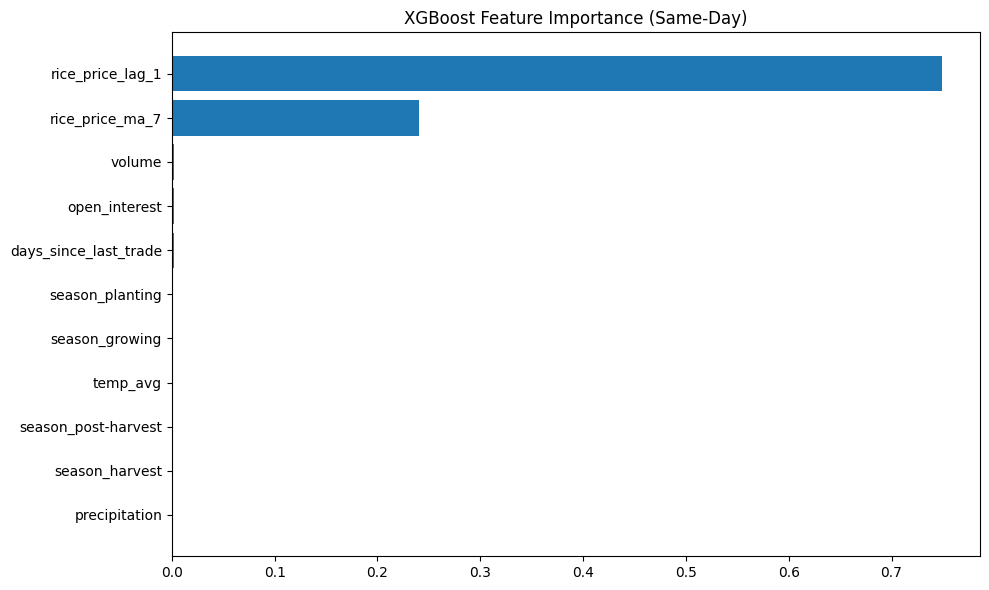

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg']).astype(np.float32)
y = df['rice_price_per_kg']

# 90/10 split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# XGBoost with reduced complexity
xgb_model = XGBRegressor(
    n_estimators=100,            # reduced from 300
    max_depth=5,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    min_child_weight=1,
    verbosity=1,
    random_state=42
)

# Train and predict
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluate
print("✅ XGBoost (Same-Day)")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

# Feature importance
importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], importances[sorted_idx])
plt.title("XGBoost Feature Importance (Same-Day)")
plt.tight_layout()
plt.show()


In [ ]:
pip install CatBoostRegressor

ERROR: Could not find a version that satisfies the requirement CatBoostRegressor (from versions: none)
ERROR: No matching distribution found for CatBoostRegressor


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load base dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])

# Keep 'season' as a label (not one-hot encoded)
season_labels = df['season']
df = pd.get_dummies(df, columns=['season'])  # one-hot version for fallback

# Prepare features: drop one-hot, keep 'season' label separately
X = df.drop(columns=['date', 'rice_price_per_kg'] + [col for col in df.columns if col.startswith("season_")])
X['season'] = season_labels  # add back original categorical
y = df['rice_price_per_kg']

# 90/10 time split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Define categorical feature index (only 'season')
cat_features = ['season']

# Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Initialize and fit model
model = CatBoostRegressor(
    iterations=200,
    depth=4,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

model.fit(train_pool)
y_pred = model.predict(test_pool)

# Evaluation
print("✅ CatBoost (Same-Day)")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

# Feature importance
importances = model.get_feature_importance()
features = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("CatBoost Feature Importance (Same-Day)")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'catboost'

In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.8 MB/s eta 0:00:00


Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 103.179
[20]	valid_0's rmse: 52.8989
[30]	valid_0's rmse: 37.9008
[40]	valid_0's rmse: 34.0724
[50]	valid_0's rmse: 32.7053
[60]	valid_0's rmse: 32.191
[70]	valid_0's rmse: 32.0006
[80]	valid_0's rmse: 31.8385
[90]	valid_0's rmse: 31.7339
[100]	valid_0's rmse: 31.7426
Early stopping, best iteration is:
[87]	valid_0's rmse: 31.707
✅ LightGBM (Same-Day)
MAE: 21.66
MSE: 1005.33
R²: -0.0251


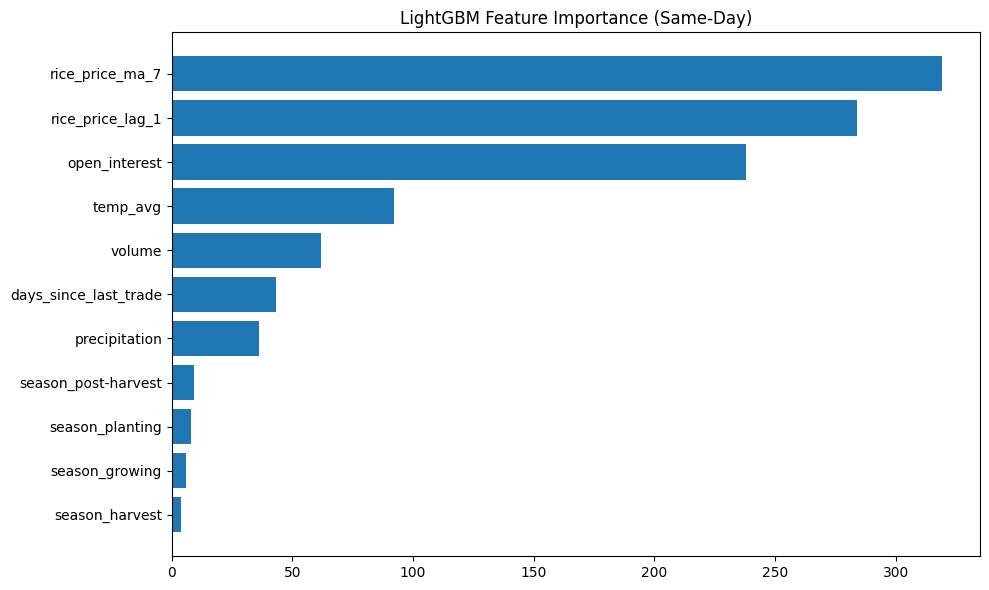

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])  # one-hot encode season

# Prepare features and target
X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# 90/10 time split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 4,
    'verbose': -1,
    'random_state': 42
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=200, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=10)])

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("✅ LightGBM (Same-Day)")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

# Feature importance
importances = model.feature_importance()
features = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("LightGBM Feature Importance (Same-Day)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# 90/10 time split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Lasso model
lasso = LassoCV(alphas=[0.01, 0.1, 1.0], max_iter=10000, cv=5)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# # LightGBM model
# train_data = lgb.Dataset(X_train, label=y_train)
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'max_depth': 4,
#     'verbose': -1,
#     'random_state': 42
# }
# lgb_model = lgb.train(params, train_data, num_boost_round=200)
# y_pred_lgb = lgb_model.predict(X_test)

# Combined prediction (equal weight)
y_pred_stacked = y_pred_lasso

# Evaluation
print("✅ Stacked Model (Lasso + LightGBM)")
print("MAE:", round(mean_absolute_error(y_test, y_pred_stacked), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred_stacked), 2))
print("R²:", round(r2_score(y_test, y_pred_stacked), 4))


✅ Stacked Model (Lasso + LightGBM)
MAE: 7.93
MSE: 133.24
R²: 0.8641


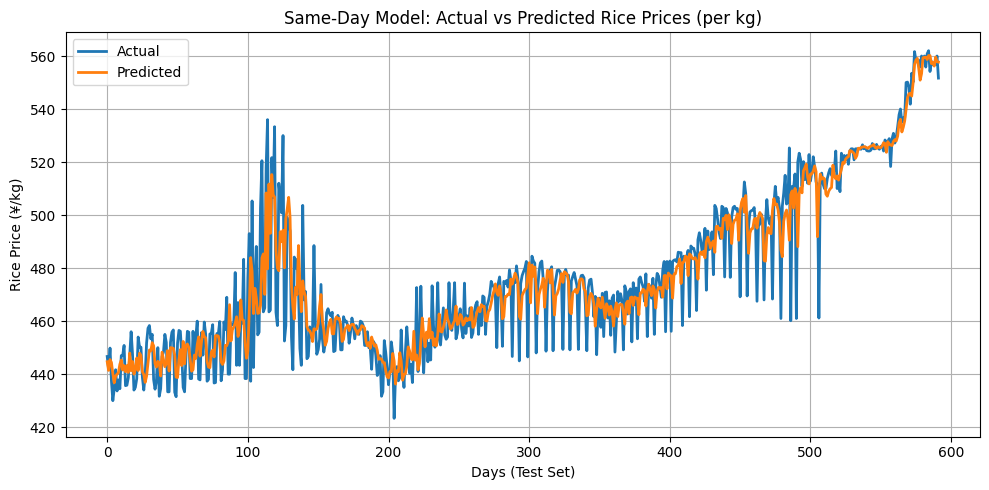

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_stacked, label='Predicted', linewidth=2)
plt.title("Same-Day Model: Actual vs Predicted Rice Prices (per kg)")
plt.xlabel("Days (Test Set)")
plt.ylabel("Rice Price (¥/kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and prepare data
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# 90/10 split
split_idx = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === Base Model 1: Lasso ===
lasso = LassoCV(alphas=[0.01, 0.1, 1.0], max_iter=10000, cv=5)
lasso.fit(X_train, y_train)
y_pred_lasso_train = lasso.predict(X_train)
y_pred_lasso_test = lasso.predict(X_test)

# === Base Model 2: LightGBM ===
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 4,
    'verbose': -1,
    'random_state': 42
}
lgb_model = lgb.train(params, train_data, num_boost_round=200)
y_pred_lgb_train = lgb_model.predict(X_train)
y_pred_lgb_test = lgb_model.predict(X_test)

# === Meta Model: Ridge on base predictions ===
# Stack base model predictions as features
X_meta_train = np.vstack([y_pred_lasso_train, y_pred_lgb_train]).T
X_meta_test = np.vstack([y_pred_lasso_test, y_pred_lgb_test]).T

ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge.fit(X_meta_train, y_train)
y_pred_stacked = ridge.predict(X_meta_test)

# === Evaluation ===
print("✅ Stacked Model (Ridge as Meta)")
print("Optimal Weights (Coefficients):", ridge.coef_)
print("MAE:", round(mean_absolute_error(y_test, y_pred_stacked), 2))
print("MSE:", round(mean_squared_error(y_test, y_pred_stacked), 2))
print("R²:", round(r2_score(y_test, y_pred_stacked), 4))


✅ Stacked Model (Ridge as Meta)
Optimal Weights (Coefficients): [-0.11508985  1.11530685]
MAE: 23.05
MSE: 1191.26
R²: -0.2147


In [ ]:
pip install shap


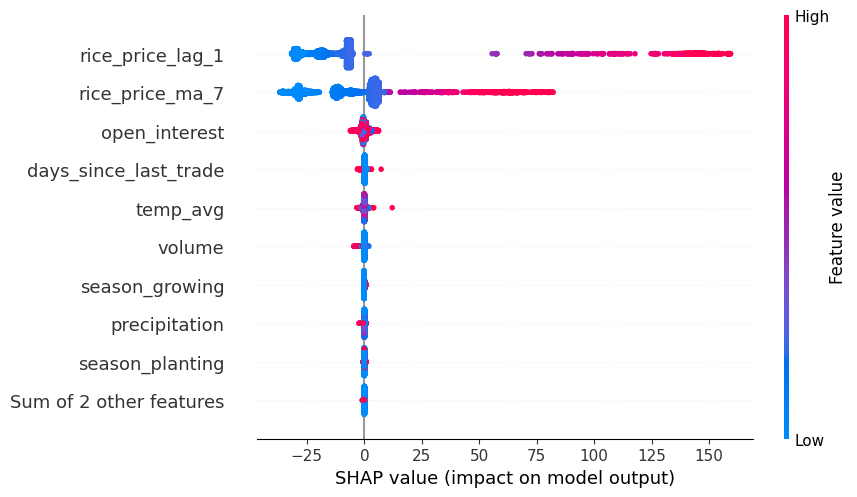

In [ ]:
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd

# Load your trained LightGBM model and input data
df = pd.read_csv("rice_model_ready_top_8_with_season.csv")
df['date'] = pd.to_datetime(df['date'])
df = pd.get_dummies(df, columns=['season'])

X = df.drop(columns=['date', 'rice_price_per_kg'])
y = df['rice_price_per_kg']

# Match the LightGBM training split
split_idx = int(len(X) * 0.9)
X_train = X.iloc[:split_idx]

# Fit LightGBM again (to use SHAP)
train_data = lgb.Dataset(X_train, label=y.iloc[:split_idx])
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': 4,
    'verbose': -1,
    'random_state': 42
}
model = lgb.train(params, train_data, num_boost_round=200)

# Explain model with SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# === Global Summary Plot (Feature importance + direction) ===
shap.plots.beeswarm(shap_values, max_display=10)

# === Optional: Local Explanation (single observation) ===
# shap.plots.waterfall(shap_values[0])
